# Hometask 11

As a homework assignment, you are asked to create a recurrent neural network using Keras mechanisms that will classify reviews from the `imdb` dataset.

Unlike the example in Module 9, we will use a recurrent neural network. Experiment with the structure of the network - RNN, LSTM, bipartite, and deep.

Compare the results and draw conclusions.

In [1]:
#install required packages
!pip install tensorflow_datasets

In [2]:
# import libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, Bidirectional, LSTM
from keras.datasets import imdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Download and Prepare the Dataset

In [3]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

2023-08-24 11:05:56.993117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [5]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"
NUM_EPOCHS = 3
BATCH_SIZE = 128

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

### Utilities
Before defining the models, need to define the function below to easily visualize the accuracy and loss history after training.

In [6]:
# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [7]:
# For saving history
def save_history(history, name):
    df_history = pd.DataFrame()
    for key in history.history.keys():
        df_history[key] = history.history[key]

    df_history.to_csv(f'{name}.csv')

history_test = []

## Model 1: Flatten
First up is simply using a Flatten layer after the embedding. Its main advantage is that it is very fast to train.

In [8]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [9]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, 
                                    training_labels_final, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=NUM_EPOCHS, 
                                    validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 2s 5ms/step - loss: 0.6107 - accuracy: 0.6592 - val_loss: 0.4030 - val_accuracy: 0.8234
Epoch 2/3
196/196 [==============================] - 1s 5ms/step - loss: 0.3166 - accuracy: 0.8703 - val_loss: 0.3360 - val_accuracy: 0.8511
Epoch 3/3
196/196 [==============================] - 1s 5ms/step - loss: 0.1983 - accuracy: 0.9300 - val_loss: 0.3570 - val_accuracy: 0.8443


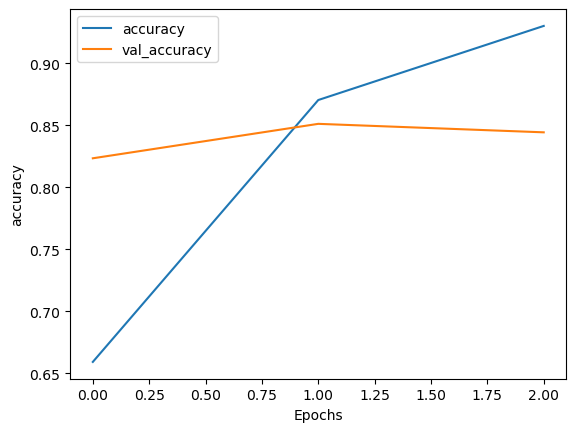

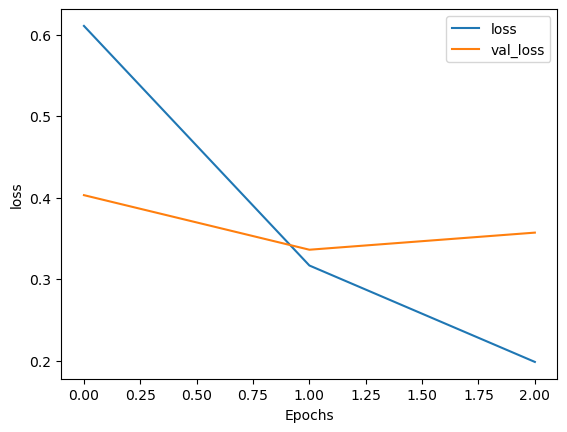

In [10]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

In [11]:
predictions = model_flatten.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 1s 944us/step
Predicted: negative, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [12]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_flatten.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 1s 1ms/step - loss: 0.3570 - accuracy: 0.8443
Test Loss: 0.3569886386394501
Test Accuracy: 0.8442800045013428


In [13]:
# saving results
save_history(history_flatten,'flatten')
history_test.append(('FLATTEN', test_loss, test_acc))

## Model 2: LSTM
This is slower to train but useful in applications where the order of the tokens is important.

In [14]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [15]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, 
                              training_labels_final, 
                              batch_size=BATCH_SIZE, 
                              epochs=NUM_EPOCHS, 
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 24s 103ms/step - loss: 0.5332 - accuracy: 0.7060 - val_loss: 0.3789 - val_accuracy: 0.8405
Epoch 2/3
196/196 [==============================] - 21s 105ms/step - loss: 0.3093 - accuracy: 0.8729 - val_loss: 0.3545 - val_accuracy: 0.8470
Epoch 3/3
196/196 [==============================] - 20s 104ms/step - loss: 0.2492 - accuracy: 0.9025 - val_loss: 0.3943 - val_accuracy: 0.8388


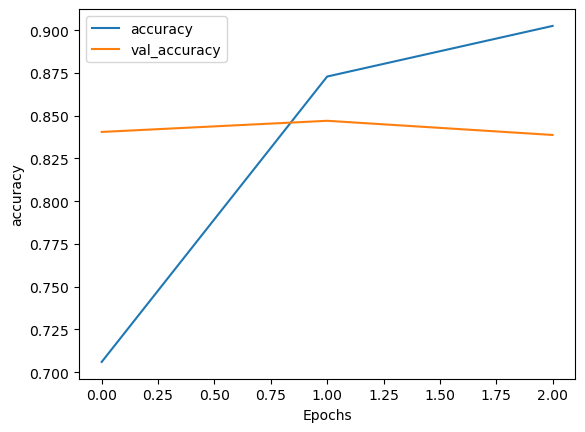

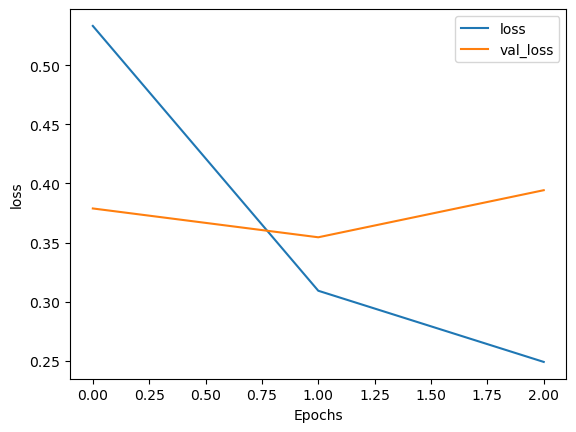

In [16]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [17]:
predictions = model_lstm.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 11s 13ms/step
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [18]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_lstm.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 11s 14ms/step - loss: 0.3943 - accuracy: 0.8388
Test Loss: 0.3943113684654236
Test Accuracy: 0.8387600183486938


In [19]:
# saving results
save_history(history_lstm,'lstm')
history_test.append(('LSTM', test_loss, test_acc))

## Model 3: GRU
The Gated Recurrent Unit or GRU is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy.

In [20]:
# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [21]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, 
                            training_labels_final, 
                            batch_size=BATCH_SIZE, 
                            epochs=NUM_EPOCHS, 
                            validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 22s 97ms/step - loss: 0.6032 - accuracy: 0.6408 - val_loss: 0.3913 - val_accuracy: 0.8338
Epoch 2/3
196/196 [==============================] - 18s 93ms/step - loss: 0.3258 - accuracy: 0.8654 - val_loss: 0.3622 - val_accuracy: 0.8400
Epoch 3/3
196/196 [==============================] - 18s 93ms/step - loss: 0.2480 - accuracy: 0.9032 - val_loss: 0.3825 - val_accuracy: 0.8343


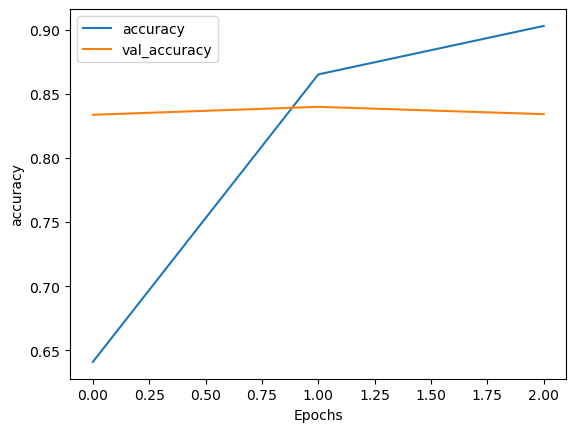

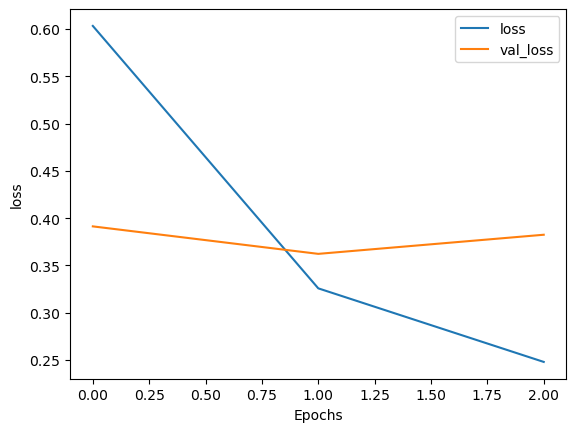

In [22]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

In [23]:
predictions = model_gru.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 9s 11ms/step
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [24]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_gru.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 9s 12ms/step - loss: 0.3825 - accuracy: 0.8343
Test Loss: 0.38246166706085205
Test Accuracy: 0.8343200087547302


In [25]:
# saving results
save_history(history_gru,'gru')
history_test.append(('GRU', test_loss, test_acc))

## Model 4: Convolution
Like the model with Flatten, this also trains much faster than the ones using RNN layers like LSTM and GRU.

In [26]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [27]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, 
                              training_labels_final, 
                              batch_size=BATCH_SIZE, 
                              epochs=NUM_EPOCHS, 
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 4s 19ms/step - loss: 0.5516 - accuracy: 0.7130 - val_loss: 0.3687 - val_accuracy: 0.8410
Epoch 2/3
196/196 [==============================] - 4s 19ms/step - loss: 0.3086 - accuracy: 0.8735 - val_loss: 0.3508 - val_accuracy: 0.8485
Epoch 3/3
196/196 [==============================] - 4s 18ms/step - loss: 0.2439 - accuracy: 0.9049 - val_loss: 0.3685 - val_accuracy: 0.8453


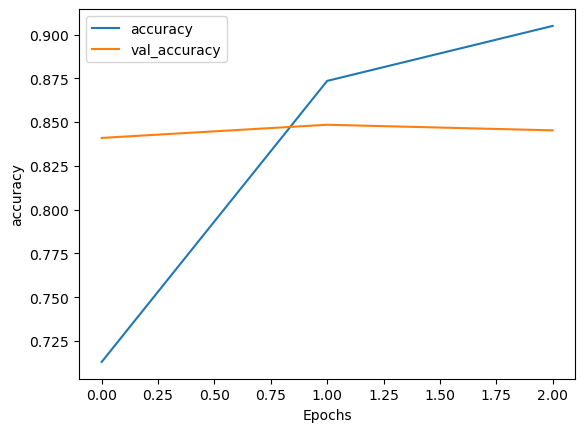

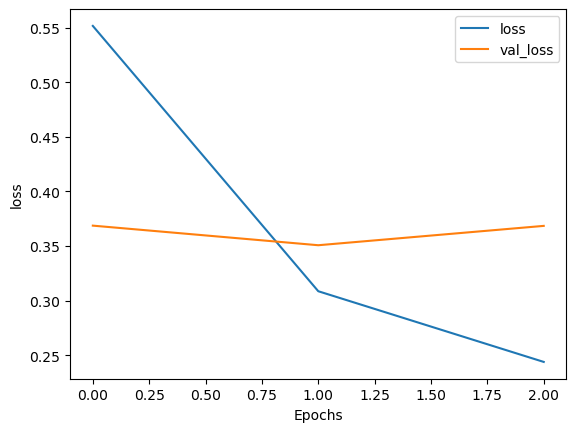

In [28]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')

In [29]:
predictions = model_conv.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 1s 2ms/step
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [30]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_conv.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 1s 2ms/step - loss: 0.3685 - accuracy: 0.8453
Test Loss: 0.368472158908844
Test Accuracy: 0.8452799916267395


In [31]:
# saving results
save_history(history_conv,'convolution')
history_test.append(('CONVOLUTION', test_loss, test_acc))

## Model 5: SRNN

In [32]:
# Parameters
max_features = 20000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
embedding_vector_length = 32

# Model Definition
model_srnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_srnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_srnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 32)           640000    
                                                                 
 dropout (Dropout)           (None, 120, 32)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 256)               8448      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 650,785
Trainable params: 650,785
Non-tr

In [33]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_srnn = model_srnn.fit(padded, 
                              training_labels_final, 
                              batch_size=BATCH_SIZE, 
                              epochs=NUM_EPOCHS, 
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 9s 39ms/step - loss: 0.6285 - accuracy: 0.6139 - val_loss: 0.4633 - val_accuracy: 0.7922
Epoch 2/3
196/196 [==============================] - 7s 38ms/step - loss: 0.4000 - accuracy: 0.8313 - val_loss: 0.4029 - val_accuracy: 0.8293
Epoch 3/3
196/196 [==============================] - 8s 39ms/step - loss: 0.2888 - accuracy: 0.8850 - val_loss: 0.3976 - val_accuracy: 0.8362


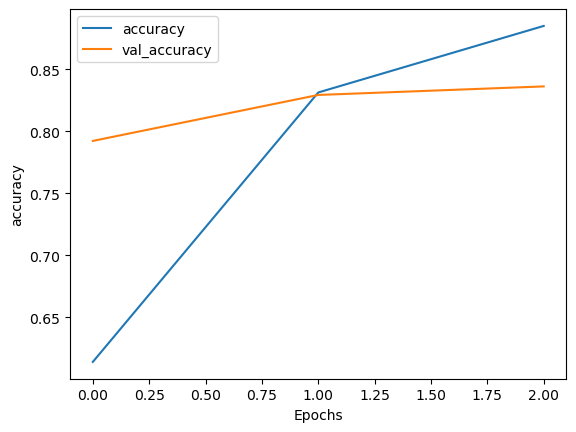

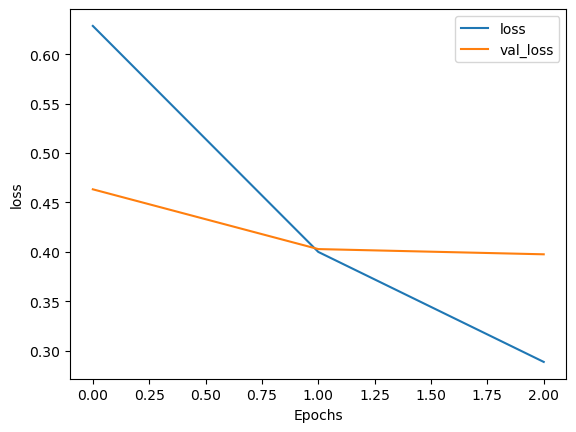

In [34]:
# Plot the accuracy and loss history
plot_graphs(history_srnn, 'accuracy')
plot_graphs(history_srnn, 'loss')

In [35]:
predictions = model_srnn.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 5s 6ms/step
Predicted: negative, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [36]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_srnn.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 4s 6ms/step - loss: 0.3976 - accuracy: 0.8362
Test Loss: 0.3975851833820343
Test Accuracy: 0.8361600041389465


In [37]:
# saving results
save_history(history_srnn,'srnn')
history_test.append(('SRNN', test_loss, test_acc))

## Model 6: BRNN

In [38]:
# Parameters
max_features = 20000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
embedding_vector_length = 32

# Model Definition
model_brnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(LSTM(32)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_brnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_brnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 32)           640000    
                                                                 
 dropout_2 (Dropout)         (None, 120, 32)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 256)               16640     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                      

In [39]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_brnn = model_brnn.fit(padded, 
                              training_labels_final, 
                              batch_size=BATCH_SIZE, 
                              epochs=NUM_EPOCHS, 
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 25s 113ms/step - loss: 0.4975 - accuracy: 0.7324 - val_loss: 0.3531 - val_accuracy: 0.8414
Epoch 2/3
196/196 [==============================] - 22s 112ms/step - loss: 0.2918 - accuracy: 0.8803 - val_loss: 0.3630 - val_accuracy: 0.8373
Epoch 3/3
196/196 [==============================] - 22s 112ms/step - loss: 0.2320 - accuracy: 0.9085 - val_loss: 0.3953 - val_accuracy: 0.8298


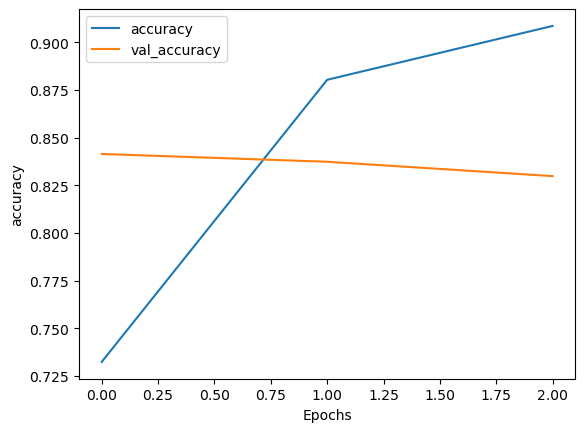

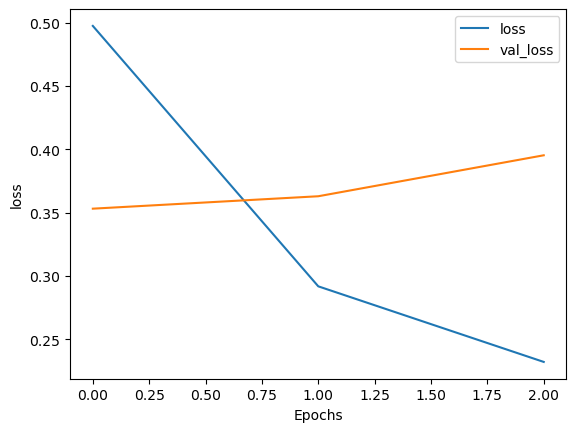

In [40]:
# Plot the accuracy and loss history
plot_graphs(history_brnn, 'accuracy')
plot_graphs(history_brnn, 'loss')

In [41]:
predictions = model_brnn.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 11s 13ms/step
Predicted: negative, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [42]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_brnn.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 11s 14ms/step - loss: 0.3953 - accuracy: 0.8298
Test Loss: 0.39532262086868286
Test Accuracy: 0.829800009727478


In [43]:
# saving results
save_history(history_brnn,'brnn')
history_test.append(('BRNN', test_loss, test_acc))

## Model 7: Deep BRNN

In [44]:
# Parameters
max_features = 20000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
embedding_vector_length = 32

# Model Definition
model_dbrnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(32)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_dbrnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_dbrnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 32)           640000    
                                                                 
 dropout_4 (Dropout)         (None, 120, 32)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 120, 64)          16640     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 256)               16640     
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [45]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_dbrnn = model_dbrnn.fit(padded, 
                              training_labels_final, 
                              batch_size=BATCH_SIZE, 
                              epochs=NUM_EPOCHS, 
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 56s 253ms/step - loss: 0.4881 - accuracy: 0.7352 - val_loss: 0.3397 - val_accuracy: 0.8516
Epoch 2/3
196/196 [==============================] - 49s 250ms/step - loss: 0.2879 - accuracy: 0.8811 - val_loss: 0.3660 - val_accuracy: 0.8418
Epoch 3/3
196/196 [==============================] - 49s 248ms/step - loss: 0.2330 - accuracy: 0.9087 - val_loss: 0.3718 - val_accuracy: 0.8430


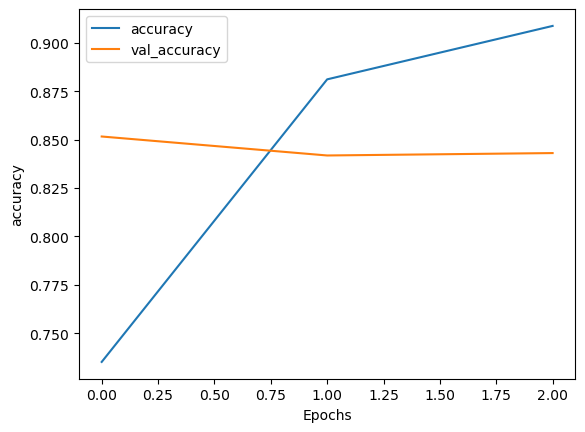

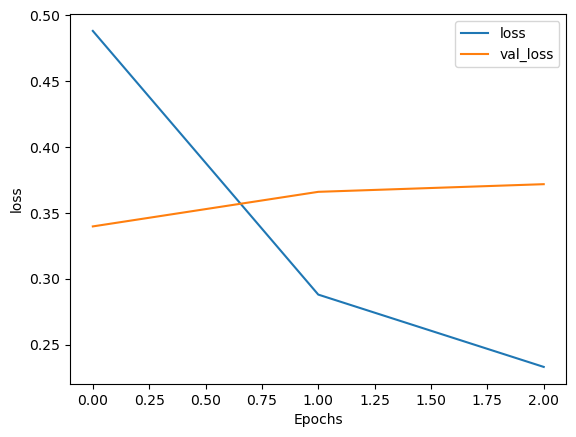

In [46]:
# Plot the accuracy and loss history
plot_graphs(history_dbrnn, 'accuracy')
plot_graphs(history_dbrnn, 'loss')

In [47]:
predictions = model_dbrnn.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 23s 27ms/step
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [48]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_dbrnn.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 22s 28ms/step - loss: 0.3718 - accuracy: 0.8430
Test Loss: 0.37175899744033813
Test Accuracy: 0.8430399894714355


In [49]:
# saving results
save_history(history_dbrnn,'dbrnn')
history_test.append(('DBRNN', test_loss, test_acc))

## Conclusion

In [50]:
csv_s = ['flatten', 'lstm', 'gru', 'convolution', 'srnn','brnn', 'dbrnn']
headers = ['Model', 'Loss', 'Accuracy']

In [51]:
data = []
for m_name in csv_s:
    df_history = pd.read_csv(m_name+'.csv')
    loss, acc = df_history['loss'][2], df_history['accuracy'][2]
    data.append((m_name.upper(), loss, acc))

In [52]:
from tabulate import tabulate
print(tabulate(data, headers=headers))

Model            Loss    Accuracy
-----------  --------  ----------
FLATTEN      0.198288     0.93004
LSTM         0.249179     0.90252
GRU          0.24801      0.90324
CONVOLUTION  0.243905     0.90492
SRNN         0.288761     0.88496
BRNN         0.232039     0.90852
DBRNN        0.233025     0.90872


In [53]:
print(tabulate(history_test, headers=headers))

Model            Loss    Accuracy
-----------  --------  ----------
FLATTEN      0.356989     0.84428
LSTM         0.394311     0.83876
GRU          0.382462     0.83432
CONVOLUTION  0.368472     0.84528
SRNN         0.397585     0.83616
BRNN         0.395323     0.8298
DBRNN        0.371759     0.84304


All used neural networks showed a fairly high and relatively equal result. From the graphs, it was found that after the 3rd epoch, all neural networks underwent retraining. Therefore, the training was limited to three epochs. The neural network with the lowest validation loss and fairly high accuracy is Flatten.